# Implementing a Neural Style Transfer Paper with Tensorflow and Keras

Link to paper:  
https://arxiv.org/pdf/1508.06576v2.pdf

References:  
https://keras.io/api/applications/vgg/#vgg19-function  
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

### In this notebook, I go through the paper and recreate it step by step

### Import things

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
from tensorflow import concat
from tensorflow import transpose
from tensorflow import reshape
from tensorflow.math import reduce_mean
from tensorflow import matmul
from tensorflow import zeros
from tensorflow import convert_to_tensor

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

from tensorflow import Variable
from tensorflow import GradientTape
from tensorflow.keras.optimizers import Adam, SGD

### Setting up the model with methods in the paper
> 1. "The results presented in the main text were generated on the basis of the VGG-Network"  
    
> 2.   "We used the feature space provided by the 16 convolutional and 5 pooling layers of the 19 layer VGGNetwork"
    
> 3.   "We do not use any of the fully connected layers"
    
> 4.   "Replacing the max-pooling operation by average pooling improves the gradient flow and one obtains slightly more appealing results"

In [3]:
model = VGG19(include_top=False, #no fully connected layers
              weights="imagenet",
              input_shape=(500, 500, 3),
              pooling='avg' #replace max-pooling with average pooling
             )

In [4]:
#check the summary to make sure we have all the neccessary layers
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [5]:
for layer in model.layers:
    layer.trainable=False

### Setting up image preprocessing

In [6]:
#paths to style input and content input images
style_path = './images/style_paintings/rains_rustle.jpg'
content_path = './images/content_images/cat.jpg'

In [7]:
# function to turn the input images into the correct size and then into tensors
def preprocess_image(img_path):
    # load an image from file
    image = load_img(img_path, target_size=(500, 500))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    return convert_to_tensor(image)

In [8]:
#turn style and content images into arrays for modeling
style_tensor = preprocess_image(style_path)
content_tensor = preprocess_image(content_path)
generated_tensor = content_tensor

### Setting up the feature extractor

In [9]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])  #outputs for every layers
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict) #make a new model that spits out the output 

### Defining "style" and "content" layers

> "Higher layers in the network capture the high-level content in terms of objects and their
arrangement in the input image but do not constrain the exact pixel values of the reconstruction ... We therefore refer to the **feature responses in higher layers of the network as the content
representation.**"

> "**Style** can also be defined more locally by including only a **smaller number of lower layers**, leading to different visual experiences"

> "For the images shown in Fig 2 we matched the **content representation on layer ‘conv4 2’** and the
**style representations on layers ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’** (wl =
1/5 in those layers, wl = 0 in all other layers) ."

In [10]:
layer_names = [layer.name for layer in model.layers]

content_layer = layer_names[13]
content_layer

'block4_conv2'

In [11]:
style_layers = layer_names[1:10:3] + layer_names[12:20:5]
style_layers

['block1_conv1',
 'block2_conv1',
 'block3_conv1',
 'block4_conv1',
 'block5_conv1']

In [12]:
style = feature_extractor(style_tensor)
content = feature_extractor(content_tensor)
generated = feature_extractor(generated_tensor)

### Visualize the outputs of style image

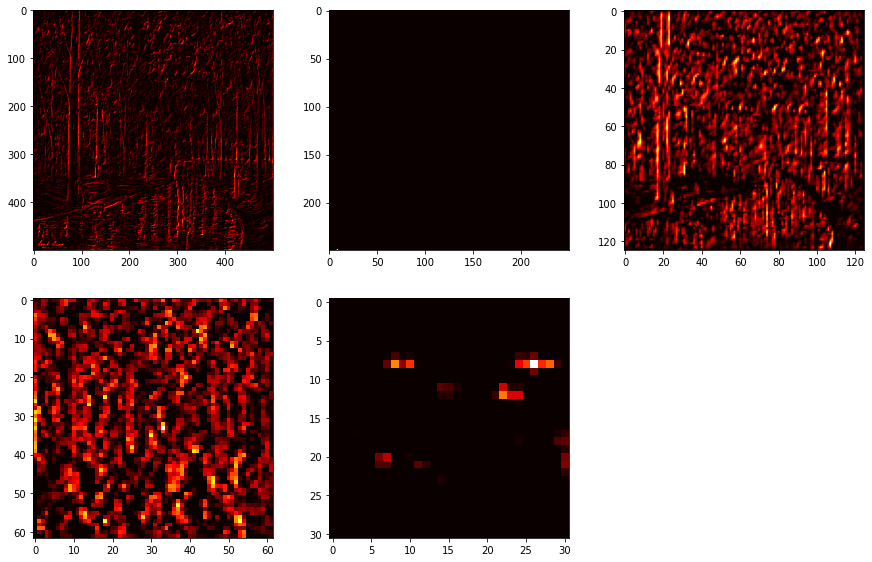

In [13]:
plt.figure(figsize=[15,15])

for i, layer in enumerate(style_layers):
    plt.subplot(3, 3, i + 1)
    plt.imshow(style[layer].numpy()[0,:,:,0], cmap='hot')

### Visualize the outputs of content image

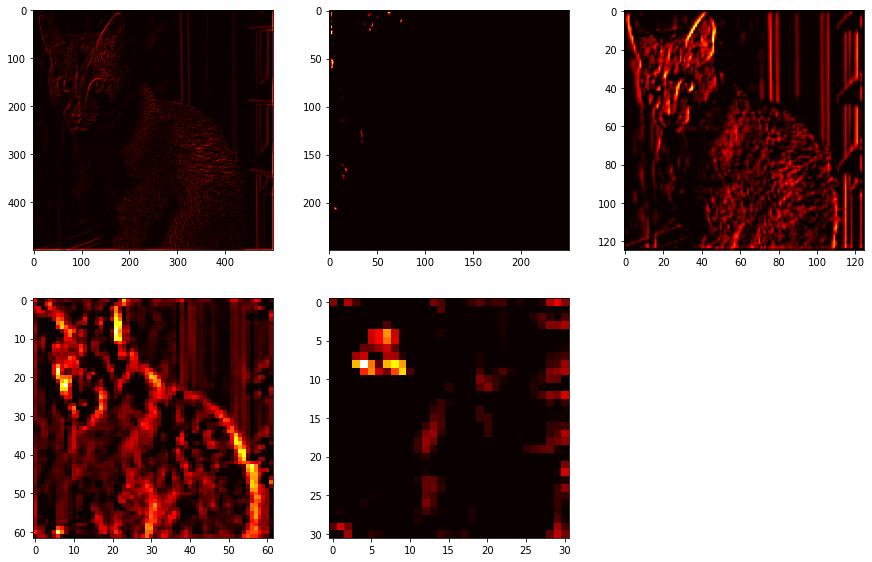

In [14]:
plt.figure(figsize=[15,15])

for i, layer in enumerate(style_layers):
    plt.subplot(3, 3, i + 1)
    plt.imshow(content[layer].numpy()[0,:,:,0], cmap='hot')

### Defining Content Loss

> "So let ~p and ~x be the original image and the image that is generated and P and F their
respective feature representation in layer l. We then define the squared-error loss between the
two feature representations:"

<img src = ./assets/contentloss.png width = 550>

In [15]:
def calc_content_loss(F, P):
    L = zeros(shape=())
    #I used reduce sum at firt, but it gives you a HUGE number
    #used reduce mean instead to keep the number a bit smaller
    L += 0.5*reduce_mean((F-P)**2).numpy()
    return L

In [16]:
#example content loss calculation:
original_image = content_tensor
generated_image = np.zeros((1, 500,500, 3))

input_tensor = concat([original_image, generated_image], axis=0)
features = feature_extractor(input_tensor)
F = features[content_layer][0, :, :, :]
P = features[content_layer][1, :, :, :]

calc_content_loss(F,P)

<tf.Tensor: shape=(), dtype=float32, numpy=243517.11>

In [17]:
#Same image = content loss of zero
original_image = content_tensor
generated_image = content_tensor

input_tensor = concat([original_image, generated_image], axis=0)
features = feature_extractor(input_tensor)
F = features[content_layer][0, :, :, :]
P = features[content_layer][1, :, :, :]

calc_content_loss(F,P)

<tf.Tensor: shape=(), dtype=float32, numpy=1.9916298e-11>

### Defining Style Loss
> "These feature correlations are given by the Gram matrix..."

<img src = ./assets/grammatrix.png  width="250">

> "...generate a texture that matches the style of a given image ... by minimising the mean-squared distance between the entries of the Gram matrix from the original image and the Gram matrix of the
image to be generated..."

<img src = ./assets/contribution.png width="450">

> "... and the total loss is:"

<img src = ./assets/styleloss.png width = "350">

> "where wl are weighting factors of the contribution of each layer to the total loss ... (wl =
1/5 in those layers)"

In [18]:
#first define gram matrix
def gram_matrix(array):
    squeezed = array[:, :, 0]
    transposed = transpose(squeezed)
    return matmul(transposed,squeezed)

In [19]:
original_style = style['block5_conv1'][0,:, :]
generated_style = generated['block5_conv1'][0,:, :]

In [20]:
#example style loss calculation
G = gram_matrix(original_style)
A = gram_matrix(generated_style)
    
#calculate the mean squared distance between the two matrices:
# I kinda just chose N and M randomly
N = 32
M = 5000
    
E = (1/(4*(N**2)*(M**2)))*sum((G-A)**2) 
style_loss = reduce_mean((1/5)*E)
style_loss

<tf.Tensor: shape=(), dtype=float32, numpy=8.340529>

In [21]:
#if style and generated are the same, style loss is 0

G = gram_matrix(original_style)
A = gram_matrix(original_style)
    
#calculate the mean squared distance between the two matrices:
# I kinda just chose N and M randomly
N = 32
M = 5000
    
E = (1/(4*(N**2)*(M**2)))*sum((G-A)**2) 
style_loss = reduce_mean((1/5)*E)
style_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Define Total Loss

> "The loss function we minimize is:"

<img src = "./assets/totalloss.png" width = 600>

> "...where α and β are the weighting factors for content and style reconstruction respectively."

In [22]:
#putting it all together:

def calc_total_loss(content_image, style_image, generated_image, alpha=0.2, beta=0.8):  
    total_loss = zeros(shape=())
    style_loss = zeros(shape=())
    
    input_tensor = concat([content_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)
    
    #calculate the content loss:
    F = features[content_layer][0,:,:,:]
    P = features[content_layer][2,:,:,:]
    content_loss = calc_content_loss(F, P)

    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2,: ,: ,:]
        
        #calculate the gram matrix:
        G = gram_matrix(style_features)
        A = gram_matrix(generated_features)
    
        #calculate the mean squared distance between the two matrices:
        # I kinda just chose N and M randomly
        N = 32
        M = 5000
    
        E = (1/(4*(N**2)*(M**2)))*sum((G-A)**2) 
        style_loss += reduce_mean((1/5)*E)
        
    #calculate total loss:
    total_loss += alpha*content_loss + beta*style_loss
    return total_loss

In [23]:
#try it out:
style = preprocess_image(style_path)
content = preprocess_image(content_path)
generated = Variable(content)

calc_total_loss(content, style, generated)

<tf.Tensor: shape=(), dtype=float32, numpy=626470.75>

In [24]:
#calculate gradients
def compute_grads(content_array, style_array, generated_array):
    with GradientTape() as tape:
        tape.watch(generated_array)
        loss = calc_total_loss(content_array, style_array, generated_array)
        grad = tape.gradient(loss, generated_array)
    return loss, grad

In [25]:
#create an optimizer
optimizer = Adam(learning_rate=20, beta_1=0.9, epsilon=0.1, amsgrad=True, name='Adam')

In [26]:
epochs = 100
for i in range(epochs):
    loss, grads = compute_grads(content, style, generated)
    optimizer.apply_gradients([(grads, generated)])
    
    if i%10 == 0:
        print(f'-------------------------\nEpoch: {i} \nTotal Loss: {loss.numpy()}')
        img = generated.numpy().squeeze()
        img = np.clip(img, 0, 255).astype("uint8")
        cv2.imwrite(f'./images/generated_images/generated_image_epoch_{i}.jpg', img)

-------------------------
Epoch: 0 
Total Loss: 626470.75
-------------------------
Epoch: 10 
Total Loss: 247496.71875
-------------------------
Epoch: 20 
Total Loss: 160626.296875
-------------------------
Epoch: 30 
Total Loss: 141546.65625
-------------------------
Epoch: 40 
Total Loss: 135524.53125
-------------------------
Epoch: 50 
Total Loss: 132142.953125
-------------------------
Epoch: 60 
Total Loss: 129301.40625
-------------------------
Epoch: 70 
Total Loss: 127542.8515625
-------------------------
Epoch: 80 
Total Loss: 126247.1953125
-------------------------
Epoch: 90 
Total Loss: 125176.8984375


KeyboardInterrupt: 

In [ ]:
final = generated.numpy().squeeze()
final = np.clip(img, 0, 255).astype("float")
cv2.imwrite(f'./images/generated_images/generated_image_epoch_final.jpg', final)